In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load ../../loaders/imports.py
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import time
import pdb

# Add the uoicorr directory to the path
sys.path.append('../../../uoicorr_run')

# Add the root directory of this repository
sys.path.append('../..')

from postprocess_utils import *
import pandas as pd
import sqlalchemy

In [3]:
from utils import gen_data, gen_covariance, sparsify_beta, gen_beta2

In [4]:
root_dir = '/media/akumar/Data/nse'

In [9]:
%store -r lasso

In [7]:
uoi = pd.read_pickle('%s/finalfinal/uoi_concat_df.dat' % root_dir)
lasso = pd.read_pickle('%s/finalfinal/lasso_concat_df.dat' % root_dir)
mcp = pd.read_pickle('%s/finalfinal/mcp_concat_df.dat' % root_dir)
scad = pd.read_pickle('%s/finalfinal/scad_concat_df.dat' % root_dir)
en = pd.read_pickle('%s/finalfinal/en_concat_df.dat' % root_dir)

In [8]:
# Remove the parasitic index field
uoi = uoi.drop('index', axis=1)
lasso = lasso.drop('index', axis=1)
mcp = mcp.drop('index', axis=1)
scad = scad.drop('index', axis=1)
en = en.drop('index', axis=1)

# Replace with a robust index
uoi.set_index(np.arange(uoi.shape[0]), inplace=True)
lasso.set_index(np.arange(lasso.shape[0]), inplace=True)
mcp.set_index(np.arange(mcp.shape[0]), inplace=True)
scad.set_index(np.arange(scad.shape[0]), inplace=True)
en.set_index(np.arange(en.shape[0]), inplace=True)

In [10]:
import pickle

In [19]:
# Load precalculated ss and eigenvalue bounds
with open('eigenvalue_bounds_kappa.dat', 'rb') as f:
    eigenvalue_bounds = pickle.load(f)
    ss = pickle.load(f)

In [9]:
with open('alpha_datalist.dat', 'rb') as f:
    alpha_datalist = pickle.load(f)

In [10]:
with open('alpha_datalist_uoi.dat', 'rb') as f:
    alpha_datalist_uoi = pickle.load(f)

### Calculation and initial plotting

In [12]:
sparsity = np.unique(uoi['sparsity'].values)

In [13]:
from expanded_ensemble import load_covariance

In [14]:
# Pre-sparsifty the beta for inverse exponential distribution and save away, as this is a time sink
sparse_beta = []
cov_idxs = np.arange(120)
for k, s in enumerate(sparsity):            
    for cov_idx in cov_idxs:
        _, cov_param = load_covariance(cov_idx)
        # take the minimum non-zero beta value
        beta = gen_beta2(500, 500, 
                         1, -1, seed=1234, distribution='normal')        
        # Sparsify beta
        beta = sparsify_beta(beta, cov_param['block_size'], s,
                             seed = cov_param['block_size'])
        sparse_beta.append({'sparsity': s, 'cov_idx': cov_idx, 'beta': beta})

In [15]:
cov_params = [] 
for cov_idx in np.arange(120):
    _, cp = load_covariance(cov_idx)
    cov_params.append(cp)

In [16]:
sparse_beta = pd.DataFrame(sparse_beta)

In [23]:
# Eigenvalue constant
def calc_alpha_sa(cov_indices, df, rho, ss_, flag, threshold=1):
    t0 = time.time()
    alphas = np.zeros(len(cov_indices))    
    sa = np.zeros((len(cov_indices)))
    for i, cov_idx in enumerate(cov_indices):
        df_ = apply_df_filters(df, cov_idx=cov_idx)        
        cov_param = cov_params[cov_idx]

        # Use pregenerated beta for inverse exp due to slow time for rejection sampling
        if df_.iloc[0]['betawidth'] == -1:
            sb = apply_df_filters(sparse_beta, cov_idx=cov_idx, sparsity=df.iloc[0]['sparsity'])
            beta = sb.iloc[0]['beta']
        else:
            # take the minimum non-zero beta value
            beta = gen_beta2(df_.iloc[0]['n_features'], df_.iloc[0]['n_features'], 1, df_.iloc[0]['betawidth'], seed=1234, distribution='normal')                
            # Sparsify beta
            beta = sparsify_beta(beta[np.newaxis, :], cov_param['block_size'], df_.iloc[0]['sparsity'], seed = cov_param['block_size'])

        beta=beta.ravel()

        alphas[i] = np.mean(rho[i] * np.min(np.abs(beta[np.nonzero(beta)[0]])**2)/ss_[i])

        # Just return the average selection accuracy
        if flag is None:
            sa[i] = np.mean(df_['sa'].values)

        if flag == 'threshold':
            sa[i] = np.count_nonzero(1 * df_.iloc[cov_indices[i]]['sa'].values > threshold)/len(cov_indices[i])
           
    return alphas, sa

In [24]:
np_ratios = np.unique(uoi['np_ratio'].values)
kappa = np.unique(uoi['kappa'].values)

In [ ]:
# Plot either the average selection accuracy or the percent of runs that exceed a certain threshold as a 
# function of the parameter alpha. alpha = rho(Omega) sum(beta_min^2)/sigma^2

# Calculate across signal to noise ratios, n/p ratio = 4
betawidth = np.unique(lasso['betawidth'].values)
selection_methods = np.unique(lasso['selection_method'])
dframes = [uoi, lasso, mcp, scad, en]
dframe_names = ['UoI Lasso', 'Lasso', 'MCP', 'SCAD', 'EN']
# Need to create a dataframe 
alpha_datalist_uoi = []

for i, dframe in enumerate(dframes):                
    for j, bw in enumerate(betawidth):
        t0 = time.time() 
        for kk, kappa_ in enumerate(kappa):
            for l, npr in enumerate(np_ratios):
                for h, sm in enumerate(selection_methods):
                    for k, s in enumerate(sparsity):            
                        df = apply_df_filters(dframe, kappa=kappa_, np_ratio=npr, selection_method=sm,
                                              betawidth=bw, sparsity=s)
                        cov_indices = np.unique(df['cov_idx'].values) 
                        alpha_, sa_ = calc_alpha_sa(cov_indices, df, rho=eigenvalue_bounds[:, k],
                                                    ss_=ss[:, k, j, kk], flag=None) 
                        alpha_datalist_uoi.append({'df_name' : dframe_names[i], 'betawidth': bw, 'sparsity' : s,
                                               'alpha': alpha_, 'sa': sa_, 'selection_method': sm,
                                                'kappa': kappa_, 'np_ratio': npr, 'cov_indices': cov_indices})       
        print('Dataframe: %s, bw_idx: %d, time: %f' % (dframe_names[i], j, time.time() - t0))

Dataframe: UoI Lasso, bw_idx: 0, time: 820.145617
Dataframe: UoI Lasso, bw_idx: 1, time: 772.207405


In [18]:
with open('alpha_datalist_uoi.dat', 'wb') as f:
    f.write(pickle.dumps(alpha_datalist_uoi))

In [44]:
with open('alpha_datalist.dat', 'wb') as f: 
    f.write(pickle.dumps(alpha_datalist))

In [75]:
# Plot either the average selection accuracy or the percent of runs that exceed a certain threshold as a 
# function of the parameter alpha. alpha = rho(Omega) sum(beta_min^2)/sigma^2

# Calculate across signal to noise ratios, n/p ratio = 4
np_ratio = 4
kappa = 5
betawidth = np.unique(lasso['betawidth'].values)
selection_method = 'BIC'

dframes = [lasso, mcp, scad, en]
#dframes = [uoi, en]
dframe_names = ['Lasso', 'MCP', 'SCAD', 'EN']

# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

cols = [c1[0], c2[0], c3[0], c4[0], c5[0]]
pal_colors = cols

# There will only be one curve over all snr, cov_params, betawidth, etc...
# np_ratio and selection methods will vary
eta = []
sa_eta = []

for i, dframe in enumerate(dframes):
    t0 = time.time()
    eta.append([])
    sa_eta.append([])
        
    for j, bw in enumerate(betawidth):
        for k, s in enumerate(sparsity):
            df = apply_df_filters(dframe, kappa=kappa, np_ratio=np_ratio, selection_method=selection_method,
                                  betawidth=bw, sparsity=s)
            cov_indices = np.unique(df['cov_idx'].values)
            eta_, sa_ = calc_eta_sa(cov_indices, df, flag=None) 
            eta[i].extend(eta_)
            sa_eta[i].extend(sa_)
            
        print('Dataframe: %s, bw_idx: %d, time: %f' % (dframe_names[i], j, time.time() - t0))

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


Dataframe: Lasso, bw_idx: 0, time: 944.877535
Dataframe: Lasso, bw_idx: 1, time: 1564.140131
Dataframe: Lasso, bw_idx: 2, time: 2184.625480
Dataframe: MCP, bw_idx: 0, time: 945.298219
Dataframe: MCP, bw_idx: 1, time: 1568.598998
Dataframe: MCP, bw_idx: 2, time: 2191.347532
Dataframe: SCAD, bw_idx: 0, time: 948.724759
Dataframe: SCAD, bw_idx: 1, time: 1570.271118
Dataframe: SCAD, bw_idx: 2, time: 2191.776856
Dataframe: EN, bw_idx: 0, time: 944.455778
Dataframe: EN, bw_idx: 1, time: 1566.170808
Dataframe: EN, bw_idx: 2, time: 2187.949424


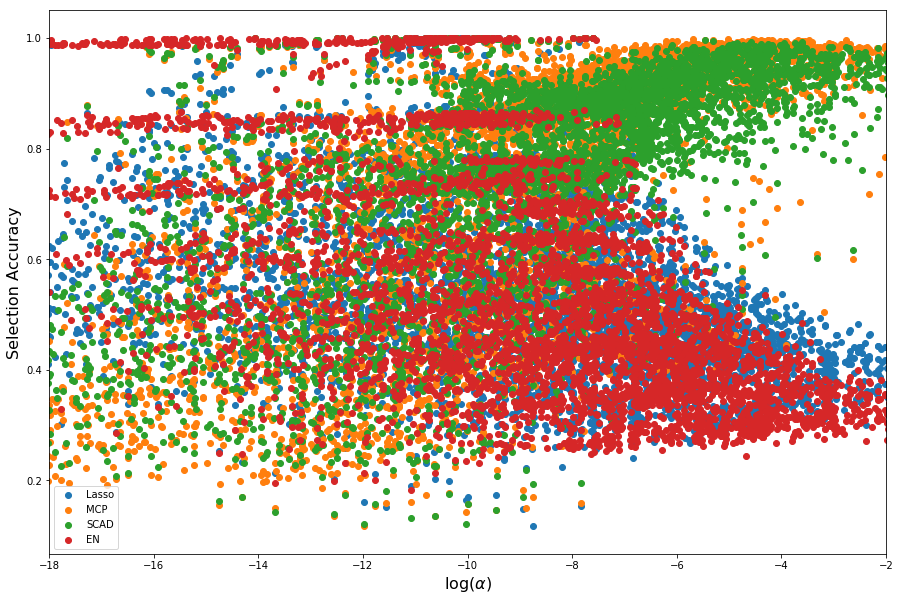

In [79]:
# Plot either the average selection accuracy or the percent of runs that exceed a certain threshold as a 
# function of the parameter alpha. alpha = rho(Omega) sum(beta_min^2)/sigma^2

# Calculate across signal to noise ratios, n/p ratio = 4
np_ratio = 4
k = 5
betawidth = np.unique(lasso['betawidth'].values)
selection_method = 'BIC'

dframes = [lasso, mcp, scad, en]
#dframes = [uoi, en]
dframe_names = ['Lasso', 'MCP', 'SCAD', 'EN']

# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

cols = [c1[0], c2[0], c3[0], c4[0], c5[0]]
pal_colors = cols


fig, ax = plt.subplots(figsize=(15, 10))

# There will only be one curve over all snr, cov_params, betawidth, etc...
# np_ratio and selection methods will vary

for i, dframe in enumerate(dframes):        
    ax.scatter(np.ma.log(alpha[i]), sa[i], label=dframe_names[i])
    
ax.set_xlim([-18, -2])
ax.set_ylabel('Selection Accuracy', fontsize=16)
ax.set_xlabel(r'$\log(\alpha)$', fontsize=16)
ax.legend()

plt.savefig('n_scalingCV.pdf', bbox_inches='tight', pad_inches=0)

In [12]:
betawidth = np.unique(lasso['betawidth'].values)
sparsity = np.unique(lasso['sparsity'].values)
kappa = np.unique(lasso['kappa'].values)

In [17]:
from plotting_utils import bound_eigenvalue

In [20]:
# To avoid redundant computations, for all unique covariance matrices and sparsity patterns, calculate the 
# eigenvalue bound.

eigenvalue_bounds = np.zeros((120, sparsity.size))

ss = np.zeros((120, sparsity.size, betawidth.size, kappa.size))

for cov_idx in np.arange(120):
    t0 = time.time()
    print(cov_idx)
    for i, s in enumerate(sparsity):
        sigma, cov_param = load_covariance(cov_idx)
        rho = 1/bound_eigenvalue(np.linalg.inv(sigma), int(s * 500))            
        eigenvalue_bounds[cov_idx, i] = rho

        for j, bw in enumerate(betawidth):
            df_ = apply_df_filters(lasso, selection_method='BIC', 
                                   betawidth = bw, cov_idx=cov_idx, sparsity=s)
            if df_.shape[0] == 0:
                ss[cov_idx, i, j] = np.nan
                print('Skipped for sparsity %f' % s)
                continue
            else:
                beta = gen_beta2(df_.iloc[0]['n_features'], df_.iloc[0]['n_features'], 1, 
                 df_.iloc[0]['betawidth'], seed=1234, distribution='normal')        
                # Sparsify beta
                beta = sparsify_beta(beta[np.newaxis, :], cov_param['block_size'], 
                                     df_.iloc[0]['sparsity'], seed = cov_param['block_size'])
                beta = beta.ravel()
                for k, kap in enumerate(kappa):
                    _, _, _, _, ss_ = gen_data(df_.iloc[0]['n_samples'], df_.iloc[0]['n_features'], 
                                              kap, sigma, beta, seed=df_.iloc[0]['seed'])

                    ss[cov_idx, i, j, k] = ss_        
    print(time.time() - t0)

0
69.45129466056824
1
67.40392971038818
2
Skipped for sparsity 0.020000
Skipped for sparsity 0.020000
Skipped for sparsity 0.020000
Skipped for sparsity 0.026448
Skipped for sparsity 0.026448
Skipped for sparsity 0.026448
Skipped for sparsity 0.034974
Skipped for sparsity 0.034974
Skipped for sparsity 0.034974
59.22735953330994
3
58.554890871047974
4
58.719175815582275
5
59.119611978530884
6
57.094974994659424
7
56.403844356536865
8
65.6051607131958
9
Skipped for sparsity 0.020000
Skipped for sparsity 0.020000
Skipped for sparsity 0.020000
Skipped for sparsity 0.026448
Skipped for sparsity 0.026448
Skipped for sparsity 0.026448
Skipped for sparsity 0.034974
Skipped for sparsity 0.034974
Skipped for sparsity 0.034974
54.820982933044434
10


/home/akumar/anaconda3/envs/nse/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]


Skipped for sparsity 0.020000
Skipped for sparsity 0.020000
Skipped for sparsity 0.020000
Skipped for sparsity 0.026448
Skipped for sparsity 0.026448
Skipped for sparsity 0.026448
Skipped for sparsity 0.034974
Skipped for sparsity 0.034974
Skipped for sparsity 0.034974
51.19203543663025
11
60.18059706687927
12
63.6861298084259
13
Skipped for sparsity 0.020000
Skipped for sparsity 0.020000
Skipped for sparsity 0.020000
Skipped for sparsity 0.026448
Skipped for sparsity 0.026448
Skipped for sparsity 0.026448
Skipped for sparsity 0.034974
Skipped for sparsity 0.034974
Skipped for sparsity 0.034974
51.32767462730408
14
62.900719165802
15
61.24900245666504
16
62.67381191253662
17
57.60174298286438
18
Skipped for sparsity 0.020000
Skipped for sparsity 0.020000
Skipped for sparsity 0.020000
Skipped for sparsity 0.026448
Skipped for sparsity 0.026448
Skipped for sparsity 0.026448
Skipped for sparsity 0.034974
Skipped for sparsity 0.034974
Skipped for sparsity 0.034974
56.15970492362976
19
58.7

Skipped for sparsity 0.034974
Skipped for sparsity 0.034974
58.53291416168213
82
76.79101586341858
83
67.43025851249695
84
Skipped for sparsity 0.020000
Skipped for sparsity 0.020000
Skipped for sparsity 0.020000
Skipped for sparsity 0.026448
Skipped for sparsity 0.026448
Skipped for sparsity 0.026448
Skipped for sparsity 0.034974
Skipped for sparsity 0.034974
Skipped for sparsity 0.034974
60.85645604133606
85
Skipped for sparsity 0.020000
Skipped for sparsity 0.020000
Skipped for sparsity 0.020000
Skipped for sparsity 0.026448
Skipped for sparsity 0.026448
Skipped for sparsity 0.026448
Skipped for sparsity 0.034974
Skipped for sparsity 0.034974
Skipped for sparsity 0.034974
59.60652136802673
86
67.69146752357483
87
66.91353821754456
88
66.67522931098938
89
Skipped for sparsity 0.020000
Skipped for sparsity 0.020000
Skipped for sparsity 0.020000
Skipped for sparsity 0.026448
Skipped for sparsity 0.026448
Skipped for sparsity 0.026448
Skipped for sparsity 0.034974
Skipped for sparsity 0

In [21]:
import pickle
with open('eigenvalue_bounds_kappa.dat', 'wb') as f:
    f.write(pickle.dumps(eigenvalue_bounds))
    f.write(pickle.dumps(ss))

### Plotting

#### First set of plots: one for each of the selection methods

In [22]:
alpha_datalist = pd.DataFrame(alpha_datalist)

In [23]:
list(alpha_datalist.keys())

['df_name', 'betawidth', 'sparsity', 'alpha', 'sa', 'selection_method']

In [12]:
from collections import OrderedDict

In [13]:
np.unique(alpha_datalist['df_name'].values)

array(['EN', 'Lasso', 'MCP', 'SCAD', 'UoI Lasso'], dtype=object)

NameError: name 'OrderedDict' is not defined

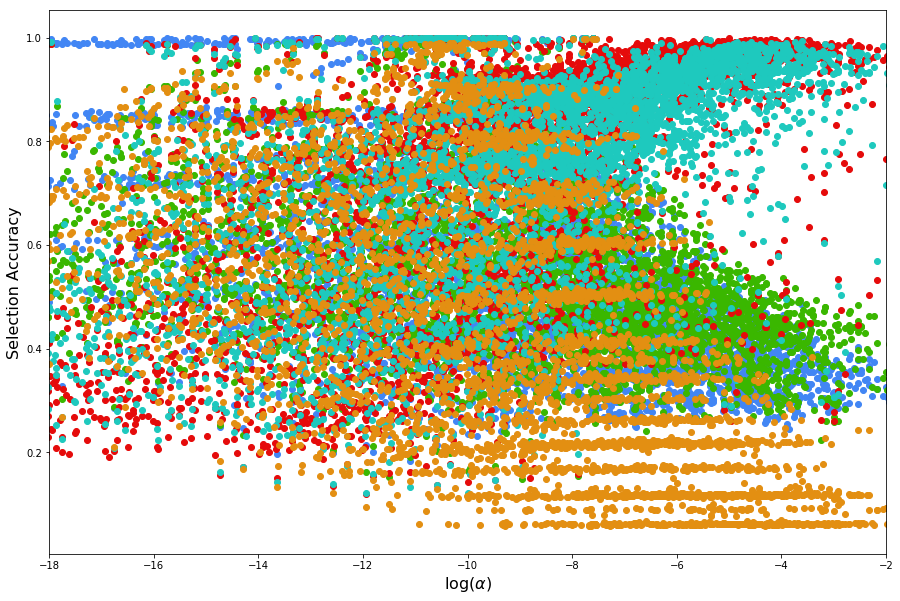

In [25]:
# Plot either the average selection accuracy or the percent of runs that exceed a certain threshold as a 
# function of the parameter alpha. alpha = rho(Omega) sum(beta_min^2)/sigma^2

# Calculate across signal to noise ratios, n/p ratio = 4
np_ratio = 4
kappa = 5
selection_method = 'CV'
dframe_names = np.unique(alpha_datalist['df_name'].values)

# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

cols = [c1[0], c2[0], c3[0], c4[0], c5[0]]
pal_colors = cols

fig, ax = plt.subplots(figsize=(15, 10))

# There will only be one curve over all snr, cov_params, betawidth, etc...
# np_ratio and selection methods will vary

for i, dframe in enumerate(dframe_names):        
    rows = apply_df_filters(alpha_datalist, df_name=dframe, selection_method=selection_method)
    for j in range(rows.shape[0]):
         ax.scatter(np.ma.log(rows.iloc[j]['alpha']), rows.iloc[j]['sa'], label=rows.iloc[j]['df_name'],
                    color=cols[list(dframe_names).index(rows.iloc[j]['df_name'])])    

ax.set_xlim([-18, -2])
ax.set_ylabel('Selection Accuracy', fontsize=16)
ax.set_xlabel(r'$\log(\alpha)$', fontsize=16)
handles, labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

In [14]:
sparsity = np.unique(alpha_datalist['sparsity'].values)
betawidth = np.unique(alpha_datalist['betawidth'].values)

In [15]:
betawidth

array([-1. ,  0.1,  inf])

In [16]:
dframe_names = ['MCP', 'SCAD', 'Lasso', 'EN', 'UoI Lasso']

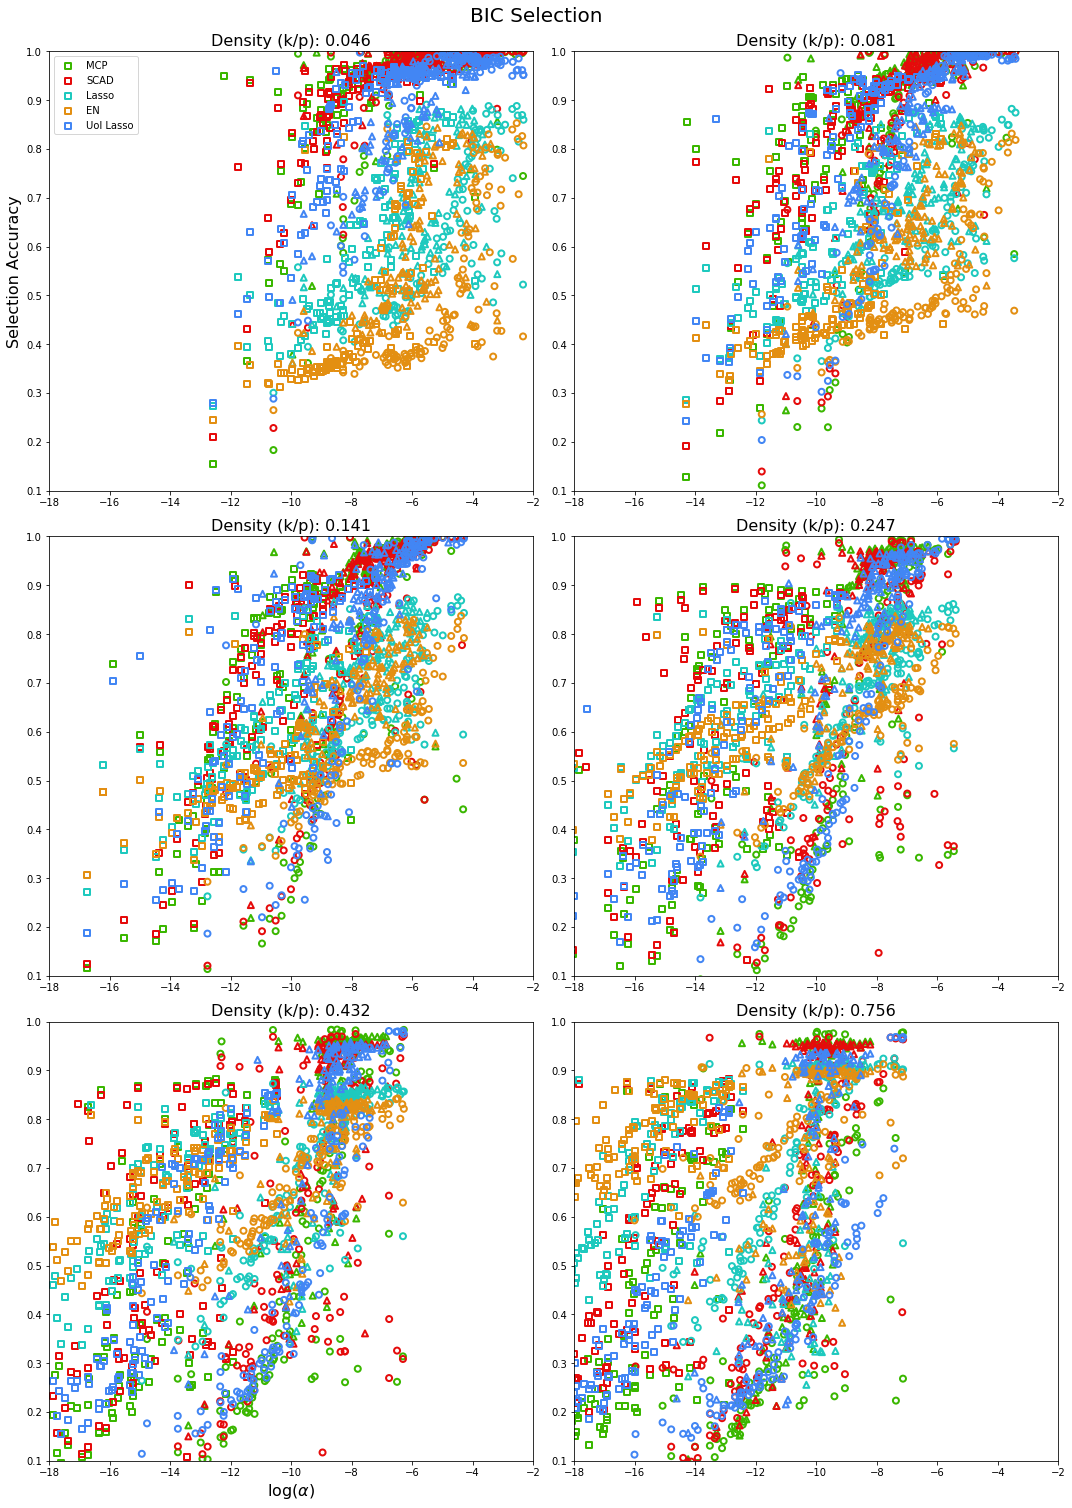

In [30]:
# Plot either the average selection accuracy or the percent of runs that exceed a certain threshold as a 
# function of the parameter alpha. alpha = rho(Omega) sum(beta_min^2)/sigma^2

# Calculate across signal to noise ratios, n/p ratio = 4
np_ratio = 4
kappa = 5
selection_method = 'BIC'
# Subsample sparsity
sparsity_ = [sparsity[3], sparsity[5], sparsity[7], sparsity[9], sparsity[11], sparsity[13]]

# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

# Per dframe
cols = [c2[0], c3[0], c4[0], c5[0], c1[0]]

# Per betawdith
marker_type = ['^', 'o', 's']
pal_colors = cols

# There will only be one curve over all snr, cov_params, betawidth, etc...
# np_ratio and selection methods will vary

# Create a separate subplot for each sparsity
fig, ax = plt.subplots(3, 2, figsize=(15, 22))

for h, s in enumerate(sparsity_):
    a = ax[np.unravel_index(h, (3,2))]
    for i, dframe in enumerate(dframe_names):      
        for k, bw in enumerate(betawidth):
            rows = apply_df_filters(alpha_datalist, df_name=dframe, selection_method=selection_method,
                                    sparsity=s, betawidth=bw)
            for j in range(rows.shape[0]):
                 a.scatter(np.ma.log(rows.iloc[j]['alpha']), rows.iloc[j]['sa'], label=rows.iloc[j]['df_name'],
                           edgecolor=cols[list(dframe_names).index(rows.iloc[j]['df_name'])],
                           marker=marker_type[k], facecolor="None", lw=2)    
                    
    a.set_xlim([-18, -2])
    a.set_ylim([0.1, 1])
    a.set_title('Density (k/p): %.3f' % s, fontsize=16)
    
ax[0, 0].set_ylabel('Selection Accuracy', fontsize=16)
ax[2, 0].set_xlabel(r'$\log(\alpha)$', fontsize=16)
handles, labels = ax[0, 0].get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax[0, 0].legend(by_label.values(), by_label.keys())

fig.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.suptitle('BIC Selection', fontsize=20)
plt.savefig('BICalpha_scaling.pdf', bbox_inches='tight', pad_inches=0)

In [40]:
np.unique(alpha_datalist['selection_method'].values)

array(['AIC', 'AIC_ols', 'BIC', 'BIC_ols', 'CV', 'empirical_bayes',
       'gMDL', 'oracle'], dtype=object)

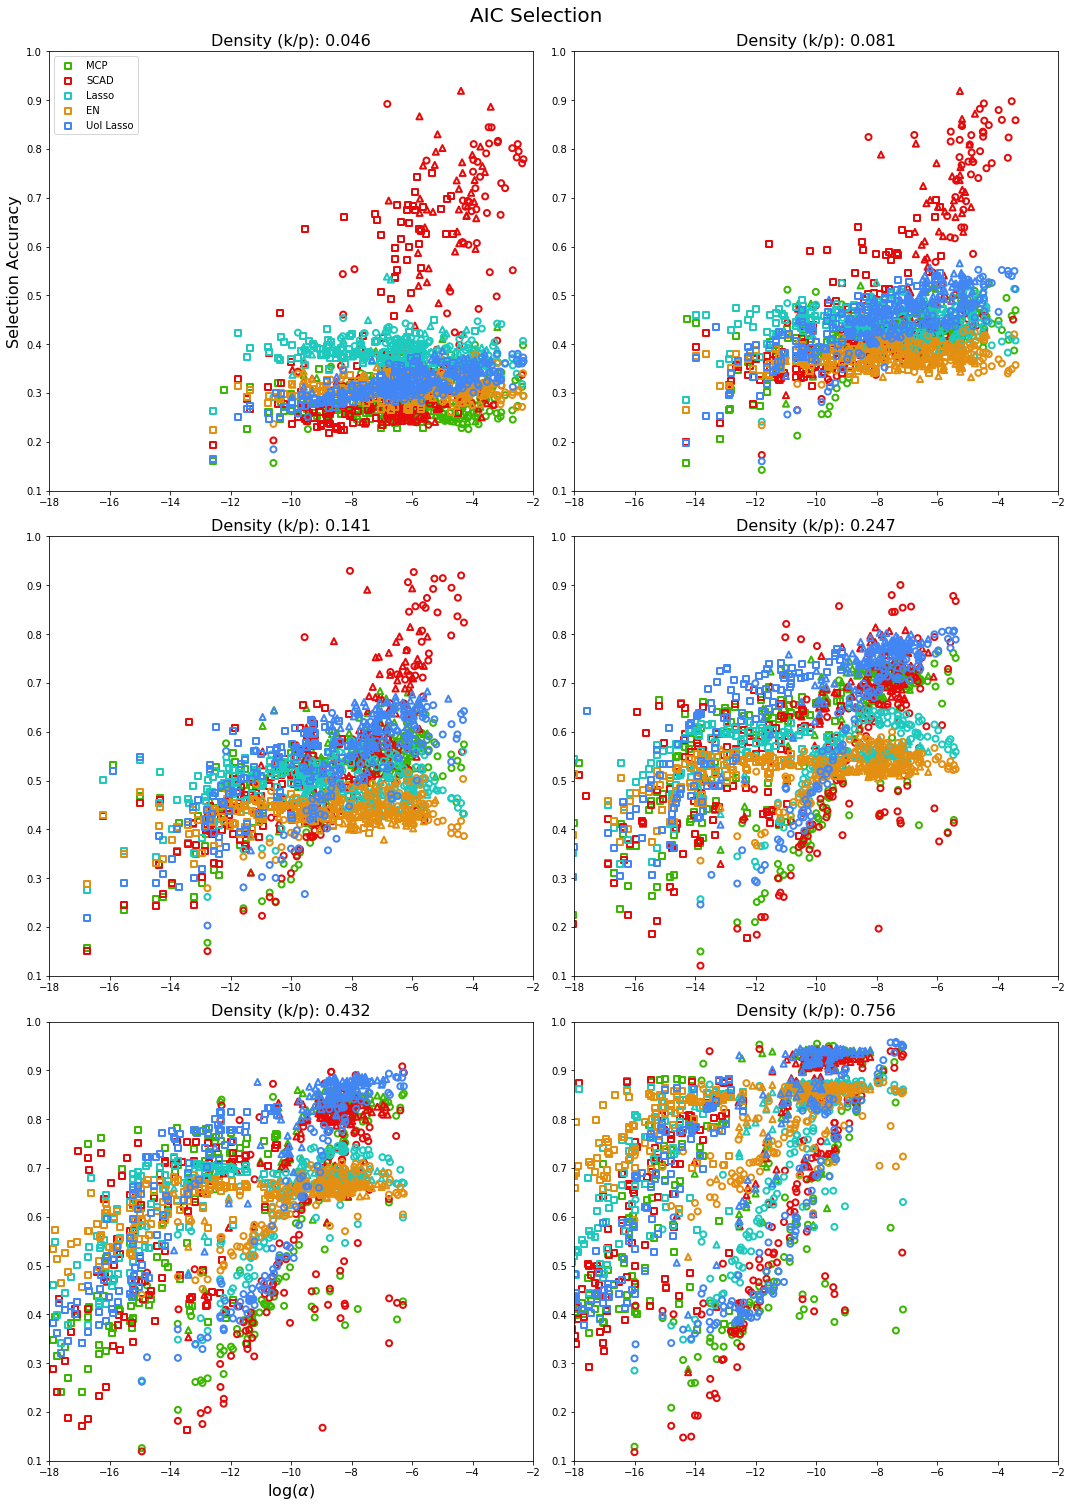

In [32]:
# Plot either the average selection accuracy or the percent of runs that exceed a certain threshold as a 
# function of the parameter alpha. alpha = rho(Omega) sum(beta_min^2)/sigma^2

# Calculate across signal to noise ratios, n/p ratio = 4
np_ratio = 4
kappa = 5
selection_method = 'AIC'
dframe_names = ['MCP', 'SCAD', 'Lasso', 'EN', 'UoI Lasso']
# Subsample sparsity
sparsity_ = [sparsity[3], sparsity[5], sparsity[7], sparsity[9], sparsity[11], sparsity[13]]

# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

# Per dframe
cols = [c2[0], c3[0], c4[0], c5[0], c1[0]]

# Per betawdith
marker_type = ['^', 'o', 's']
pal_colors = cols

# There will only be one curve over all snr, cov_params, betawidth, etc...
# np_ratio and selection methods will vary

# Create a separate subplot for each sparsity
fig, ax = plt.subplots(3, 2, figsize=(15, 22))

for h, s in enumerate(sparsity_):
    a = ax[np.unravel_index(h, (3,2))]
    for i, dframe in enumerate(dframe_names):      
        for k, bw in enumerate(betawidth):
            rows = apply_df_filters(alpha_datalist, df_name=dframe, selection_method=selection_method,
                                    sparsity=s, betawidth=bw)
            for j in range(rows.shape[0]):
                 a.scatter(np.ma.log(rows.iloc[j]['alpha']), rows.iloc[j]['sa'], label=rows.iloc[j]['df_name'],
                           edgecolor=cols[list(dframe_names).index(rows.iloc[j]['df_name'])],
                           marker=marker_type[k], facecolor="None", lw=2)    
                    
    a.set_xlim([-18, -2])
    a.set_ylim([0.1, 1])
    a.set_title('Density (k/p): %.3f' % s, fontsize=16)
    
ax[0, 0].set_ylabel('Selection Accuracy', fontsize=16)
ax[2, 0].set_xlabel(r'$\log(\alpha)$', fontsize=16)
handles, labels = ax[0, 0].get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax[0, 0].legend(by_label.values(), by_label.keys())

fig.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.suptitle('AIC Selection', fontsize=20)
plt.savefig('AIC_alpha_scaling.pdf', bbox_inches='tight', pad_inches=0)

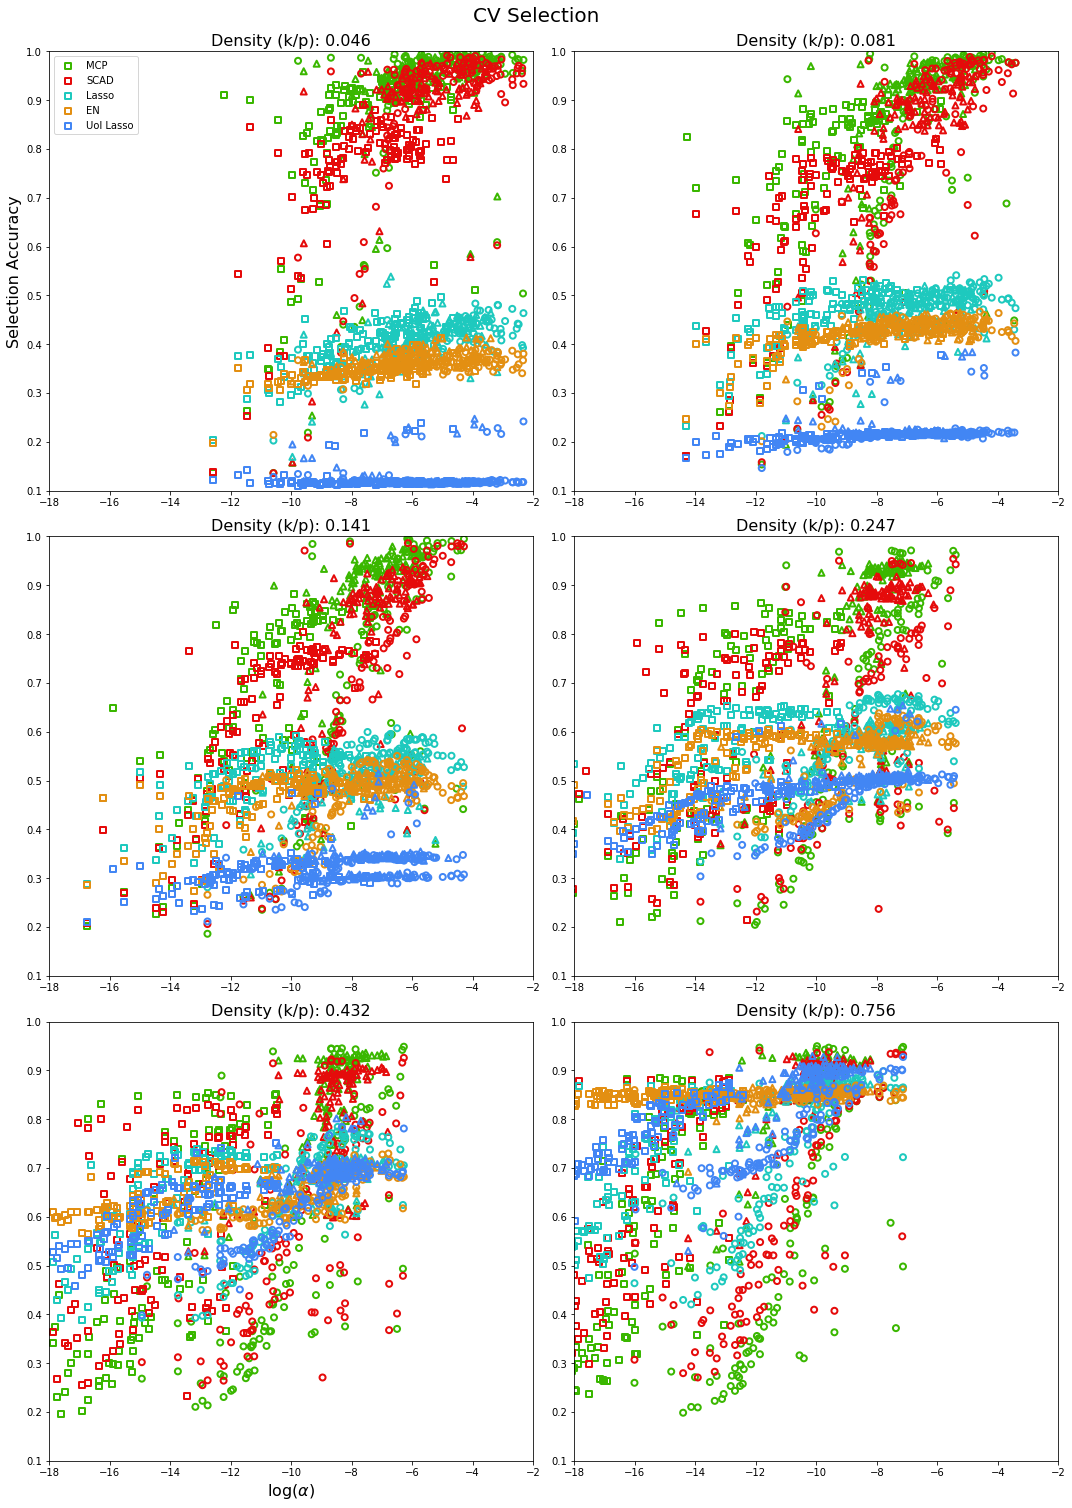

In [34]:
# Plot either the average selection accuracy or the percent of runs that exceed a certain threshold as a 
# function of the parameter alpha. alpha = rho(Omega) sum(beta_min^2)/sigma^2

# Calculate across signal to noise ratios, n/p ratio = 4
np_ratio = 4
kappa = 5
selection_method = 'CV'
dframe_names = ['MCP', 'SCAD', 'Lasso', 'EN', 'UoI Lasso']
# Subsample sparsity
sparsity_ = [sparsity[3], sparsity[5], sparsity[7], sparsity[9], sparsity[11], sparsity[13]]

# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

# Per dframe
cols = [c2[0], c3[0], c4[0], c5[0], c1[0]]

# Per betawdith
marker_type = ['^', 'o', 's']
pal_colors = cols

# There will only be one curve over all snr, cov_params, betawidth, etc...
# np_ratio and selection methods will vary

# Create a separate subplot for each sparsity
fig, ax = plt.subplots(3, 2, figsize=(15, 22))

for h, s in enumerate(sparsity_):
    a = ax[np.unravel_index(h, (3,2))]
    for i, dframe in enumerate(dframe_names):      
        for k, bw in enumerate(betawidth):
            rows = apply_df_filters(alpha_datalist, df_name=dframe, selection_method=selection_method,
                                    sparsity=s, betawidth=bw)
            for j in range(rows.shape[0]):
                 a.scatter(np.ma.log(rows.iloc[j]['alpha']), rows.iloc[j]['sa'], label=rows.iloc[j]['df_name'],
                           edgecolor=cols[list(dframe_names).index(rows.iloc[j]['df_name'])],
                           marker=marker_type[k], facecolor="None", lw=2)    
                    
    a.set_xlim([-18, -2])
    a.set_ylim([0.1, 1])
    a.set_title('Density (k/p): %.3f' % s, fontsize=16)
    
ax[0, 0].set_ylabel('Selection Accuracy', fontsize=16)
ax[2, 0].set_xlabel(r'$\log(\alpha)$', fontsize=16)
handles, labels = ax[0, 0].get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax[0, 0].legend(by_label.values(), by_label.keys())

fig.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.suptitle('CV Selection', fontsize=20)
plt.savefig('CValpha_scaling.pdf', bbox_inches='tight', pad_inches=0)

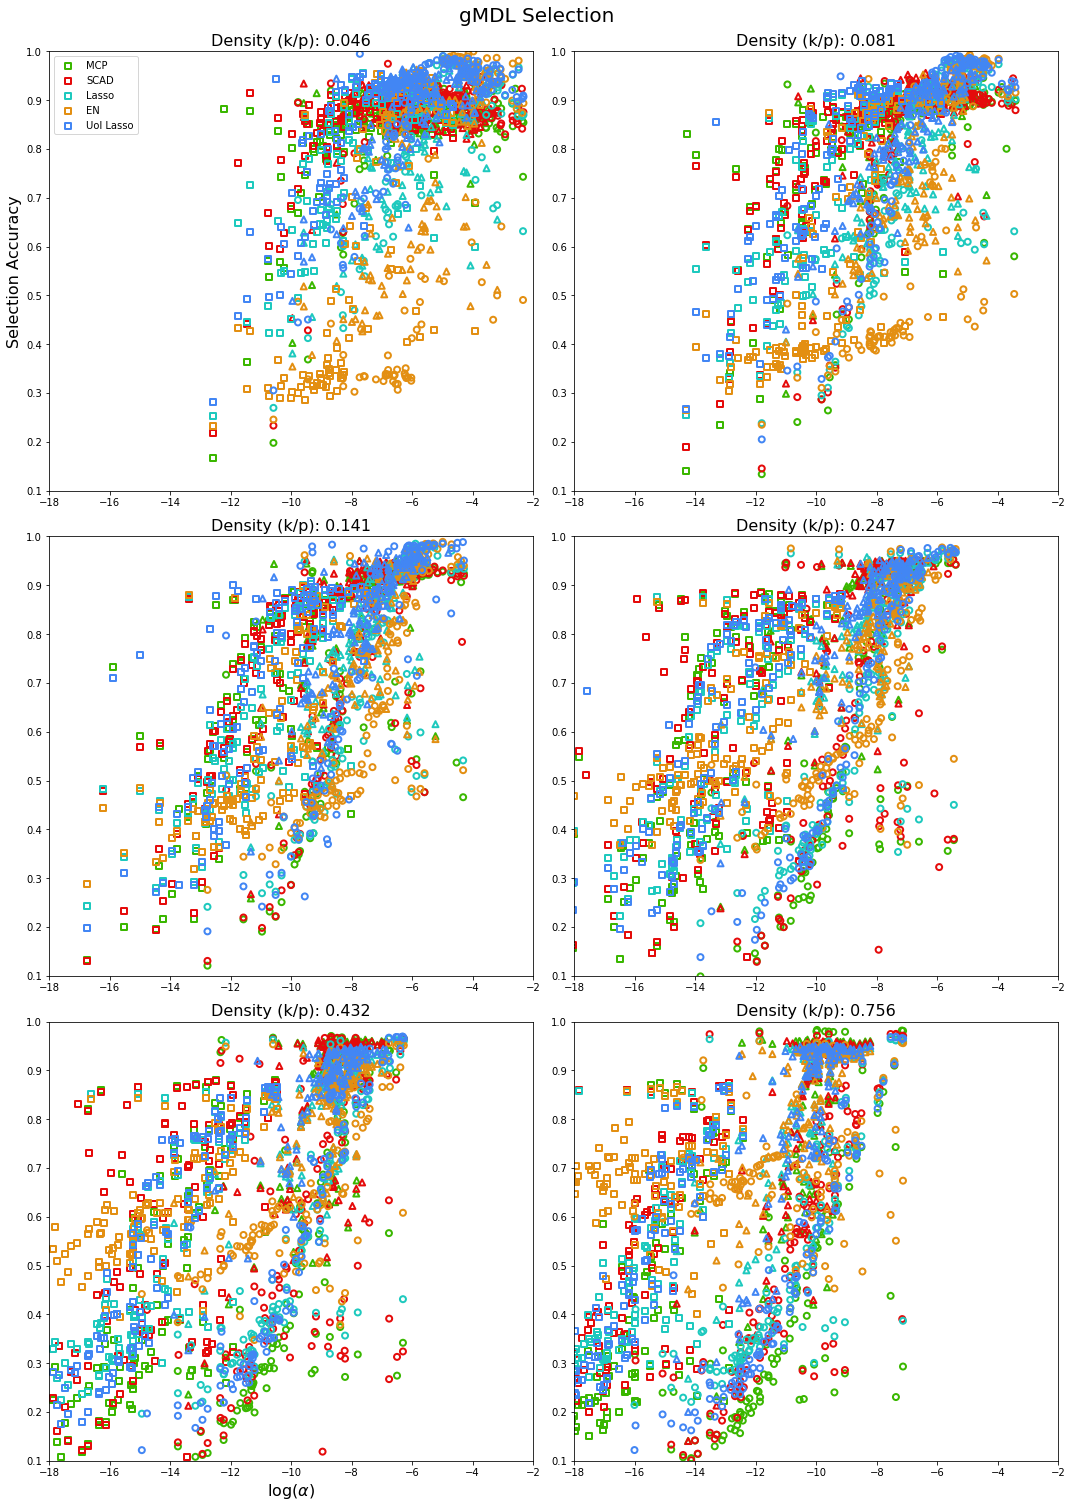

In [35]:
# Plot either the average selection accuracy or the percent of runs that exceed a certain threshold as a 
# function of the parameter alpha. alpha = rho(Omega) sum(beta_min^2)/sigma^2

# Calculate across signal to noise ratios, n/p ratio = 4
np_ratio = 4
kappa = 5
selection_method = 'gMDL'
dframe_names = ['MCP', 'SCAD', 'Lasso', 'EN', 'UoI Lasso']

# Subsample sparsity
sparsity_ = [sparsity[3], sparsity[5], sparsity[7], sparsity[9], sparsity[11], sparsity[13]]

# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

# Per dframe
cols = [c2[0], c3[0], c4[0], c5[0], c1[0]]

# Per betawdith
marker_type = ['^', 'o', 's']
pal_colors = cols

# There will only be one curve over all snr, cov_params, betawidth, etc...
# np_ratio and selection methods will vary

# Create a separate subplot for each sparsity
fig, ax = plt.subplots(3, 2, figsize=(15, 22))

for h, s in enumerate(sparsity_):
    a = ax[np.unravel_index(h, (3,2))]
    for i, dframe in enumerate(dframe_names):      
        for k, bw in enumerate(betawidth):
            rows = apply_df_filters(alpha_datalist, df_name=dframe, selection_method=selection_method,
                                    sparsity=s, betawidth=bw)
            for j in range(rows.shape[0]):
                 a.scatter(np.ma.log(rows.iloc[j]['alpha']), rows.iloc[j]['sa'], label=rows.iloc[j]['df_name'],
                           edgecolor=cols[list(dframe_names).index(rows.iloc[j]['df_name'])],
                           marker=marker_type[k], facecolor="None", lw=2)    
                    
    a.set_xlim([-18, -2])
    a.set_ylim([0.1, 1])
    a.set_title('Density (k/p): %.3f' % s, fontsize=16)
    
ax[0, 0].set_ylabel('Selection Accuracy', fontsize=16)
ax[2, 0].set_xlabel(r'$\log(\alpha)$', fontsize=16)
handles, labels = ax[0, 0].get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax[0, 0].legend(by_label.values(), by_label.keys())

fig.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.suptitle('gMDL Selection', fontsize=20)
plt.savefig('gMDLalpha_scaling.pdf', bbox_inches='tight', pad_inches=0)

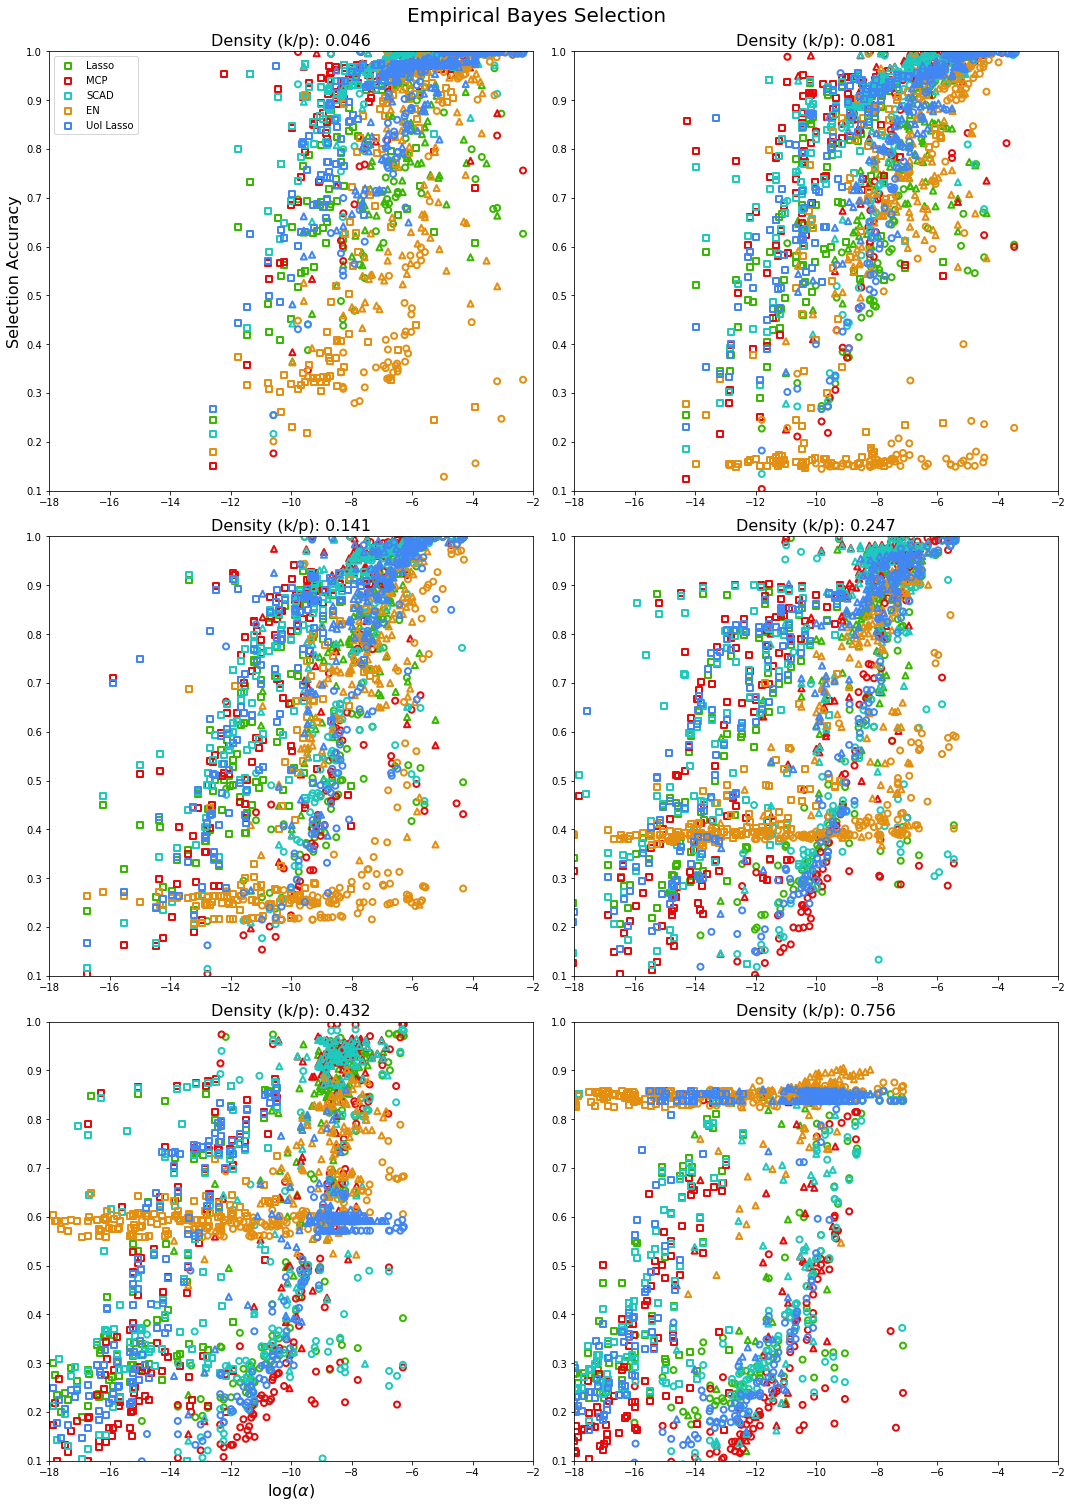

In [36]:
# Plot either the average selection accuracy or the percent of runs that exceed a certain threshold as a 
# function of the parameter alpha. alpha = rho(Omega) sum(beta_min^2)/sigma^2

# Calculate across signal to noise ratios, n/p ratio = 4
np_ratio = 4
kappa = 5
selection_method = 'empirical_bayes'
dframe_names = ['Lasso', 'MCP', 'SCAD', 'EN', 'UoI Lasso']

# Subsample sparsity
sparsity_ = [sparsity[3], sparsity[5], sparsity[7], sparsity[9], sparsity[11], sparsity[13]]

# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

# Per dframe
cols = [c2[0], c3[0], c4[0], c5[0], c1[0]]

# Per betawdith
marker_type = ['^', 'o', 's']
pal_colors = cols

# There will only be one curve over all snr, cov_params, betawidth, etc...
# np_ratio and selection methods will vary

# Create a separate subplot for each sparsity
fig, ax = plt.subplots(3, 2, figsize=(15, 22))

for h, s in enumerate(sparsity_):
    a = ax[np.unravel_index(h, (3,2))]
    for i, dframe in enumerate(dframe_names):      
        for k, bw in enumerate(betawidth):
            rows = apply_df_filters(alpha_datalist, df_name=dframe, selection_method=selection_method,
                                    sparsity=s, betawidth=bw)
            for j in range(rows.shape[0]):
                 a.scatter(np.ma.log(rows.iloc[j]['alpha']), rows.iloc[j]['sa'], label=rows.iloc[j]['df_name'],
                           edgecolor=cols[list(dframe_names).index(rows.iloc[j]['df_name'])],
                           marker=marker_type[k], facecolor="None", lw=2)    
                    
    a.set_xlim([-18, -2])
    a.set_ylim([0.1, 1])
    a.set_title('Density (k/p): %.3f' % s, fontsize=16)
    
ax[0, 0].set_ylabel('Selection Accuracy', fontsize=16)
ax[2, 0].set_xlabel(r'$\log(\alpha)$', fontsize=16)
handles, labels = ax[0, 0].get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax[0, 0].legend(by_label.values(), by_label.keys())

fig.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.suptitle('Empirical Bayes Selection', fontsize=20)
plt.savefig('EBalpha_scaling.pdf', bbox_inches='tight', pad_inches=0)

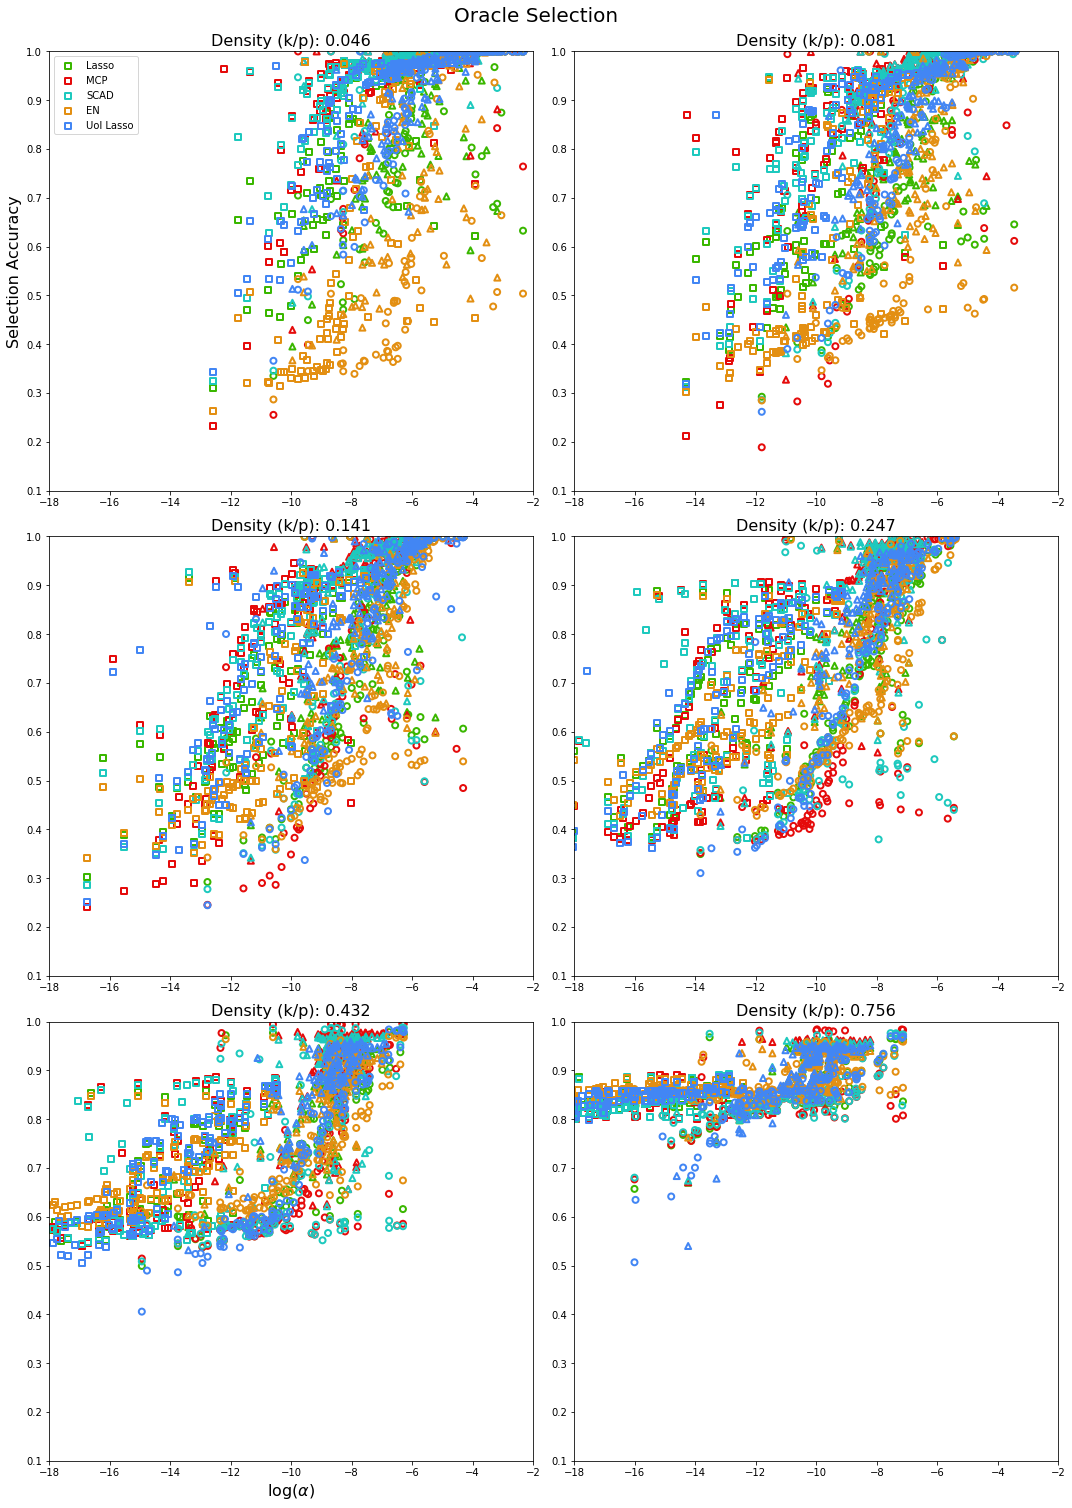

In [37]:
# Plot either the average selection accuracy or the percent of runs that exceed a certain threshold as a 
# function of the parameter alpha. alpha = rho(Omega) sum(beta_min^2)/sigma^2

# Calculate across signal to noise ratios, n/p ratio = 4
np_ratio = 4
kappa = 5
selection_method = 'oracle'
dframe_names = ['Lasso', 'MCP', 'SCAD', 'EN', 'UoI Lasso']
# Subsample sparsity
sparsity_ = [sparsity[3], sparsity[5], sparsity[7], sparsity[9], sparsity[11], sparsity[13]]

# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

# Per dframe
cols = [c2[0], c3[0], c4[0], c5[0], c1[0]]

# Per betawdith
marker_type = ['^', 'o', 's']
pal_colors = cols

# There will only be one curve over all snr, cov_params, betawidth, etc...
# np_ratio and selection methods will vary

# Create a separate subplot for each sparsity
fig, ax = plt.subplots(3, 2, figsize=(15, 22))

for h, s in enumerate(sparsity_):
    a = ax[np.unravel_index(h, (3,2))]
    for i, dframe in enumerate(dframe_names):      
        for k, bw in enumerate(betawidth):
            rows = apply_df_filters(alpha_datalist, df_name=dframe, selection_method=selection_method,
                                    sparsity=s, betawidth=bw)
            for j in range(rows.shape[0]):
                 a.scatter(np.ma.log(rows.iloc[j]['alpha']), rows.iloc[j]['sa'], label=rows.iloc[j]['df_name'],
                           edgecolor=cols[list(dframe_names).index(rows.iloc[j]['df_name'])],
                           marker=marker_type[k], facecolor="None", lw=2)    
                    
    a.set_xlim([-18, -2])
    a.set_ylim([0.1, 1])
    a.set_title('Density (k/p): %.3f' % s, fontsize=16)
    
ax[0, 0].set_ylabel('Selection Accuracy', fontsize=16)
ax[2, 0].set_xlabel(r'$\log(\alpha)$', fontsize=16)
handles, labels = ax[0, 0].get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax[0, 0].legend(by_label.values(), by_label.keys())

fig.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.suptitle('Oracle Selection', fontsize=20)
plt.savefig('oracle_alpha_scaling.pdf', bbox_inches='tight', pad_inches=0)

In [22]:
from sklearn.linear_model import LinearRegression

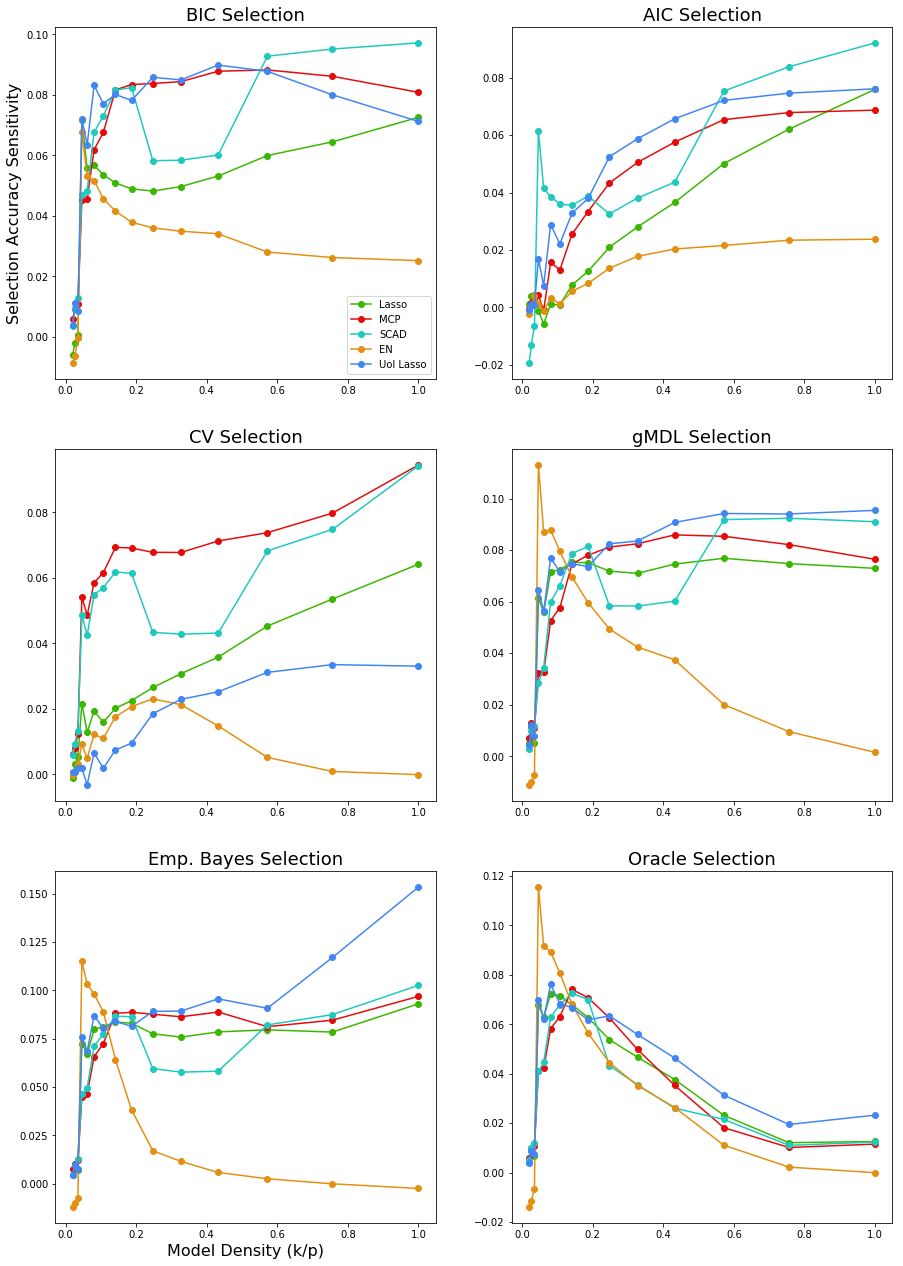

In [31]:
# Summary statistic # 1: Correlation value at which the algorithm gets to half (or the max)
# Calculate across signal to noise ratios, n/p ratio = 4
np_ratio = 4
kappa = 5
dframe_names = ['Lasso', 'MCP', 'SCAD', 'EN', 'UoI Lasso']

# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

# Per dframe
cols = [c2[0], c3[0], c4[0], c5[0], c1[0]]

fig, ax = plt.subplots(3, 2, figsize=(15, 22))

selection_method_names = ['BIC', 'AIC', 'CV', 'gMDL', 'Emp. Bayes', 'Oracle']
selection_methods = ['BIC', 'AIC', 'CV', 'gMDL', 'empirical_bayes', 'oracle']

for i, sm in enumerate(selection_methods):
    a = ax[np.unravel_index(i, (3,2))]
    for j, dframe in enumerate(dframe_names):      
        for k, bw in enumerate([np.inf]):
            yy = np.zeros(sparsity.size)
            for l, s in enumerate(sparsity):
                rows = apply_df_filters(alpha_datalist, df_name=dframe, selection_method=sm,
                                        sparsity=s, betawidth=bw)
                # Fit a quadratic model to the data and extract when the function achieves half of
                # its maximum on the interval
                alpha_mask = np.ma.log(rows['alpha'].values[0])
                mask = np.invert(alpha_mask.mask)
                alpha_ = np.log(rows['alpha'].values[0][mask])
                sa_ = rows['sa'].values[0][mask]
#                model = SVR(kernel='rbf').fit(alpha_.reshape(-1, 1), sa_)
                # predict over the range
                model = LinearRegression(normalize=True, fit_intercept=True).fit(alpha_.reshape(-1, 1), sa_) 
                yy[l] = model.coef_.ravel()[0]
        
            a.plot(sparsity, yy, '-o', c=cols[j],  label=dframe_names[j])
            a.set_title('%s Selection' % selection_method_names[i], fontsize = 18)

            
ax[0, 0].set_ylabel('Selection Accuracy Sensitivity', fontsize=16)
ax[2, 0].set_xlabel('Model Density (k/p)', fontsize=16)
handles, labels = ax[0, 0].get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax[0, 0].legend(by_label.values(), by_label.keys())

plt.savefig('alpha_summary.pdf', bbox_inches='tight', pad_inches=0)


In [3]:
import pickle
with open('alpha_datalist_expanded.dat', 'rb') as f:
    alpha_datalist = pickle.load(f)

In [ ]:
# Also collapse the signal to noise ratio on the above